# Working with automated computations: Imported and Computed tables

Welcome back! In this session, we are going to continue working with the pipeline for the Mouse electrophysiology example. In this session, we will learn to:

* import neuron activity data from data files into `Imported` tables
* compute various statistics for each neuron by defining a `Computed` table
* define a `Lookup` table to store parameters for computation
* define a `Computed` table to perform spike detection
* automatically perform computations for all missing entries with `populate`

First thing first, let's import `datajoint` again.

In [ ]:
import datajoint as dj

As we are going to perform some computations, go ahead and import NumPy as well as Matplotlib.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we would like to continue working with the tables we defined in the previous notebook. To do so, we would need the `Classes` for each table. We can either redefine it here, but for your convenience, we have included the schema and table class definitions in a file `session2.py` that you can simply import.

In [25]:
from session2 import schema, Mouse, Session

The pipeline module includes the `schema` object, as well as classes for `Mouse` and `Session`

In [26]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2017-03-01,M,
1,2016-11-19,M,
2,2016-11-20,unknown,
5,2016-12-25,F,
10,2017-01-01,F,
11,2017-01-03,F,
100,2017-05-12,F,


In [27]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
0,2017-05-15,0,Edgar Y. Walker
0,2017-05-19,0,Edgar Y. Walker
5,2017-01-05,1,Fabian Sinz
100,2017-05-25,100,Jacob Reimer


We also went ahead and added a few more entries into the table.

# Importing data from data files

In the `data` directory, you will fine 4 `.npy` (saved NumPy array) files with names like `data_100_2017-05-25.npy`. 

As you might have guessed, these are the data for the 4 recording sessions in the Session table, and each file are named according to the `mouse_id` and `session_date` - the attributes of the primary keys - in the format `data_{mouse_id}_{session_date}.npy`

Let's take a quick peak at the data content.

In [15]:
import numpy as np
data = np.load('data/data_0_2017-05-15.npy')
data.shape

(1000,)

So this particular file contains a NumPy array of length 1000. This represents a (simulated) recording of raw electric activity from a single neuron over 1000 time bins.

We now would like to have all these recorded `Neuron` represented and stored in a table. Since we only record a single neuron from each session, a `Neuron` can be uniquely identified by knowing the `Session` it was recorded in. For each `Neuron`, we want to store the neural activity found in the data file.

In [100]:
schema

Schema database: `eywalker_workshop_fix`

In [101]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """

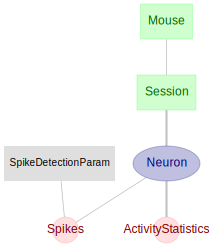

In [102]:
dj.ERD(schema)

Note that we have declared the above table as `dj.Imported` instaed of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**.

We defined `activity` as a longblob so that it can store a NumPy array holding the electric activity over time. This NumPy array will be imported from the file corresponding to each neuron.

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic to automatically figure out what needs to be imported and perform the import!

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's try calling it.

In [29]:
Neuron.populate()

NotImplementedError: Subclasses of AutoPopulate must implement the method `make`

Notice that `populate` call complained that a method called `make` is not implemented. Let me show a simple `make` method that will help elucidate what this is all about.

In [30]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """
    def make(self, key): # `make` takes a single argument `key`
        print(key)

Now, let's call `populate` again!

In [31]:
Neuron.populate()

{'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)}
{'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19)}
{'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5)}
{'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25)}


When you call `populate` on an `Imported` table, this triggers DataJoint to look up all the other tables that the `Imported` table depends on, and for each primary key of the dependent table, call `make` function on.

Because `Neuron` depends on `Session`, `Neuron`'s make method was called for each entry of `Session`

In [33]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
0,2017-05-15,0,Edgar Y. Walker
0,2017-05-19,0,Edgar Y. Walker
5,2017-01-05,1,Fabian Sinz
100,2017-05-25,100,Jacob Reimer


Note that `make` only receives the *primary key attributes* of `Session` (`mouse_id` and `session_date`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [34]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """
    def _make_tuples(self, key):
        # use key dictionary to determine the data file path
        data_file = "data/data_{mouse_id}_{session_date}.npy".format(**key)

        # load the data
        data = np.load(data_file)

        # add the loaded data as the "activity" column
        key['activity'] = data

        # insert the key into self
        self.insert1(key)

        print('Populated a neuron for {mouse_id} on {session_date}'.format(**key))

Finally, let's go ahead and call `populate` to actually populate the `Neuron` table, with data loaded from data files!

In [35]:
Neuron.populate()

Populated a neuron for 0 on 2017-05-15
Populated a neuron for 0 on 2017-05-19
Populated a neuron for 5 on 2017-01-05
Populated a neuron for 100 on 2017-05-25


In [36]:
Neuron()

mouse_id Unique animal ID,session_date date,activity electric activity of the neuron
0,2017-05-15,=BLOB=
0,2017-05-19,=BLOB=
5,2017-01-05,=BLOB=
100,2017-05-25,=BLOB=


What happens if we call `Neuron.populate` again?

In [37]:
Neuron.populate()

That's right, nothing! This makes sense, because we have imported `Neuron` for all entries in `Session` and noting is left to be imported.

Now what happens if we insert a new entry in `Session`?

In [45]:
Session.insert1({
    "mouse_id": 100,
    "session_date": "2017-06-01",
    "experiment_setup": 1,
    "experimenter": "Jacob Reimer"
    ""
})

DataJointError: Duplicate entry '100-2017-06-01' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

We can find all `Session` without corresponding `Neuron` entry with the **antijoin operator** `-`

In [42]:
Session - Neuron

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
100,2017-06-01,1,Jacob Reimer


In [43]:
Neuron.populate()

Populated a neuron for 100 on 2017-06-01


In [44]:
Neuron()

mouse_id Unique animal ID,session_date date,activity electric activity of the neuron
0,2017-05-15,=BLOB=
0,2017-05-19,=BLOB=
5,2017-01-05,=BLOB=
100,2017-05-25,=BLOB=
100,2017-06-01,=BLOB=


# Computations in data pipeline

Now we have successfully imported all data we have into our pipeline, it's time for us to start analyzing the data! When you perform computations in the DataJoint data pipeline, you focus and design tables in terms of **what** is it that you are computing rather than the **how**!

Now, let's say that we want to compute the satististics, such as mean, standard deviation, and maximum value of each of our neuron traces. Hence we want to compute the neuron's **activity statistics** for each neuron!

So the entity here is `ActivityStatistics`, where each entry corresponds to the statistics of a single `Neuron` entry. Let's start designing the table, paying special attention to the dependencies.

### Statistics of neuron activities

In [49]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

    def make(self, key):
        activity = (Neuron() & key).fetch1('activity')    # fetch activity as NumPy array

        # compute various statistics on activity
        key['mean'] = activity.mean()   # compute mean
        key['stdev'] = activity.std()   # compute standard deviation
        key['max'] = activity.max()     # compute max
        self.insert1(key)
        print('Computed statistics for mouse_id {mouse_id} session_date {session_date}'.format(**key))

In [50]:
ActivityStatistics.populate()

In [51]:
ActivityStatistics()

mouse_id Unique animal ID,session_date date,mean mean activity,stdev standard deviation of activity,max maximum activity
0,2017-05-15,0.207357,0.400867,2.48161
0,2017-05-19,0.13274,0.291462,1.82805
5,2017-01-05,0.0891786,0.236412,1.37389
100,2017-05-25,0.21907,0.328783,1.76383
100,2017-06-01,0.0873266,0.237858,1.32454


# Spike detection

Now, let's go ahead and tack a more challenging computation. While having raw neural traces in itself can be quite interesting, nothing is as exciting as spikes! Let's take a look at our activity.

In [52]:
# fetch all activities
activities = Neuron.fetch('activity')

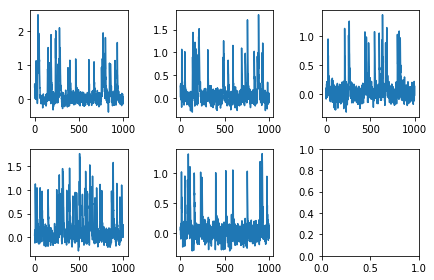

In [58]:
fig, axs = plt.subplots(2, 3)
for activity, ax in zip(activities, axs.ravel()):
    ax.plot(activity)

fig.tight_layout()

Let's now focus on one trace.

In [61]:
activity = activities[0]

(0, 300)

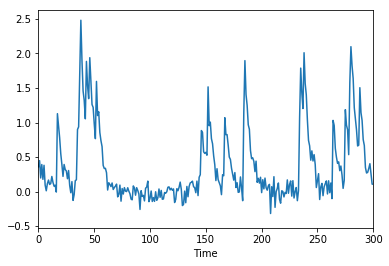

In [80]:
plt.plot(activity)
plt.xlabel('Time')
plt.xlim([0, 300])

Perhaps we can use threshold to detect when a spike occured. Threshold of `0.5` may be a good start.

(0, 300)

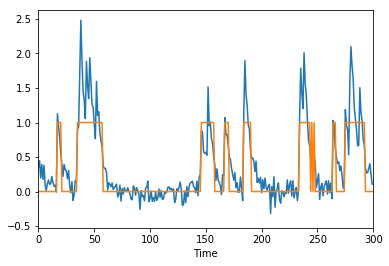

In [85]:
threshold = 0.5

above_thrs = (activity > threshold).astype(np.int)   # find activity above threshold

plt.plot(activity)
plt.plot(above_thrs)
plt.xlabel('Time')
plt.xlim([0, 300])

We want to find out **when** it crossed the threshold.

(0, 300)

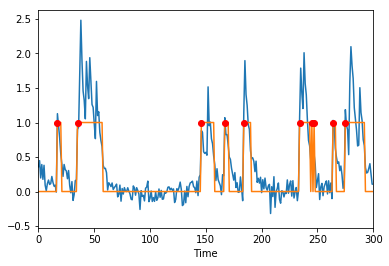

In [84]:
rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro');
plt.xlabel('Time')
plt.xlim([0, 300])

Finally find the spike counts

In [83]:
count = spikes.sum()   # compute total spike counts
count

26

Now notice that the exact spikes you detect depends on the value of the `threshold`. Hence, `threshold` is a parameter for your computation. Rather than fixing the value of the threshold, we might want to try different values and see what values work well. In other words, you want to compute `Spikes` for a **combination** of `Neuron`s and different `Threshold` values. To do this while still taking advantage of the `make` and `populate` logic, you would want to define a table to house parameters for spike detection in a `Lookup` table!

## Parameter `Lookup` table

Let's define `SpikeDetectionParam` table to hold different parameter configuration for our spike detection algorithm. We are going to define this table as a `Lookup` table, rather than a `Manual` table.

In [72]:
@schema
class SpikeDetectionParam(dj.Lookup):
    definition = """
    sdp_id: int      # unique id for spike detection parameter set
    ---
    threshold: float   # threshold for spike detection
    """

### Defining `Spikes` table

In [87]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """
    def make(self, key):
        print('Populating for: ', key)

        activity = (Neuron() & key).fetch1('activity')
        threshold = (SpikeDetectionParam() & key).fetch1('threshold')

        above_thrs = (activity > threshold).astype(np.int)   # find activity above threshold
        rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
        spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

        count = spikes.sum()   # compute total spike counts
        print('Detected {} spikes!\n'.format(count))

        # save results and insert
        key['spikes'] = spikes
        key['count'] = count
        self.insert1(key)

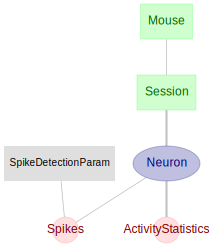

In [103]:
dj.ERD(schema)

In [89]:
Spikes()

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes


In [90]:
Spikes.populate()

In [91]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection


In [92]:
SpikeDetectionParam.insert1((0, 0.5))

In [93]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5


In [94]:
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 0}
Detected 26 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 0}
Detected 24 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 0}
Detected 18 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'sdp_id': 0}
Detected 41 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 6, 1), 'sdp_id': 0}
Detected 18 spikes!



In [95]:
Spikes()

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,=BLOB=,26
0,2017-05-19,0,=BLOB=,24
5,2017-01-05,0,=BLOB=,18
100,2017-05-25,0,=BLOB=,41
100,2017-06-01,0,=BLOB=,18


In [96]:
SpikeDetectionParam.insert1((1, 0.9))

In [97]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5
1,0.9


In [98]:
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 1}
Detected 27 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 1}
Detected 21 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 1}
Detected 14 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'sdp_id': 1}
Detected 35 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 6, 1), 'sdp_id': 1}
Detected 15 spikes!



In [99]:
Spikes()

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,=BLOB=,26
0,2017-05-15,1,=BLOB=,27
0,2017-05-19,0,=BLOB=,24
0,2017-05-19,1,=BLOB=,21
5,2017-01-05,0,=BLOB=,18
5,2017-01-05,1,=BLOB=,14
100,2017-05-25,0,=BLOB=,41
100,2017-05-25,1,=BLOB=,35
100,2017-06-01,0,=BLOB=,18
100,2017-06-01,1,=BLOB=,15
